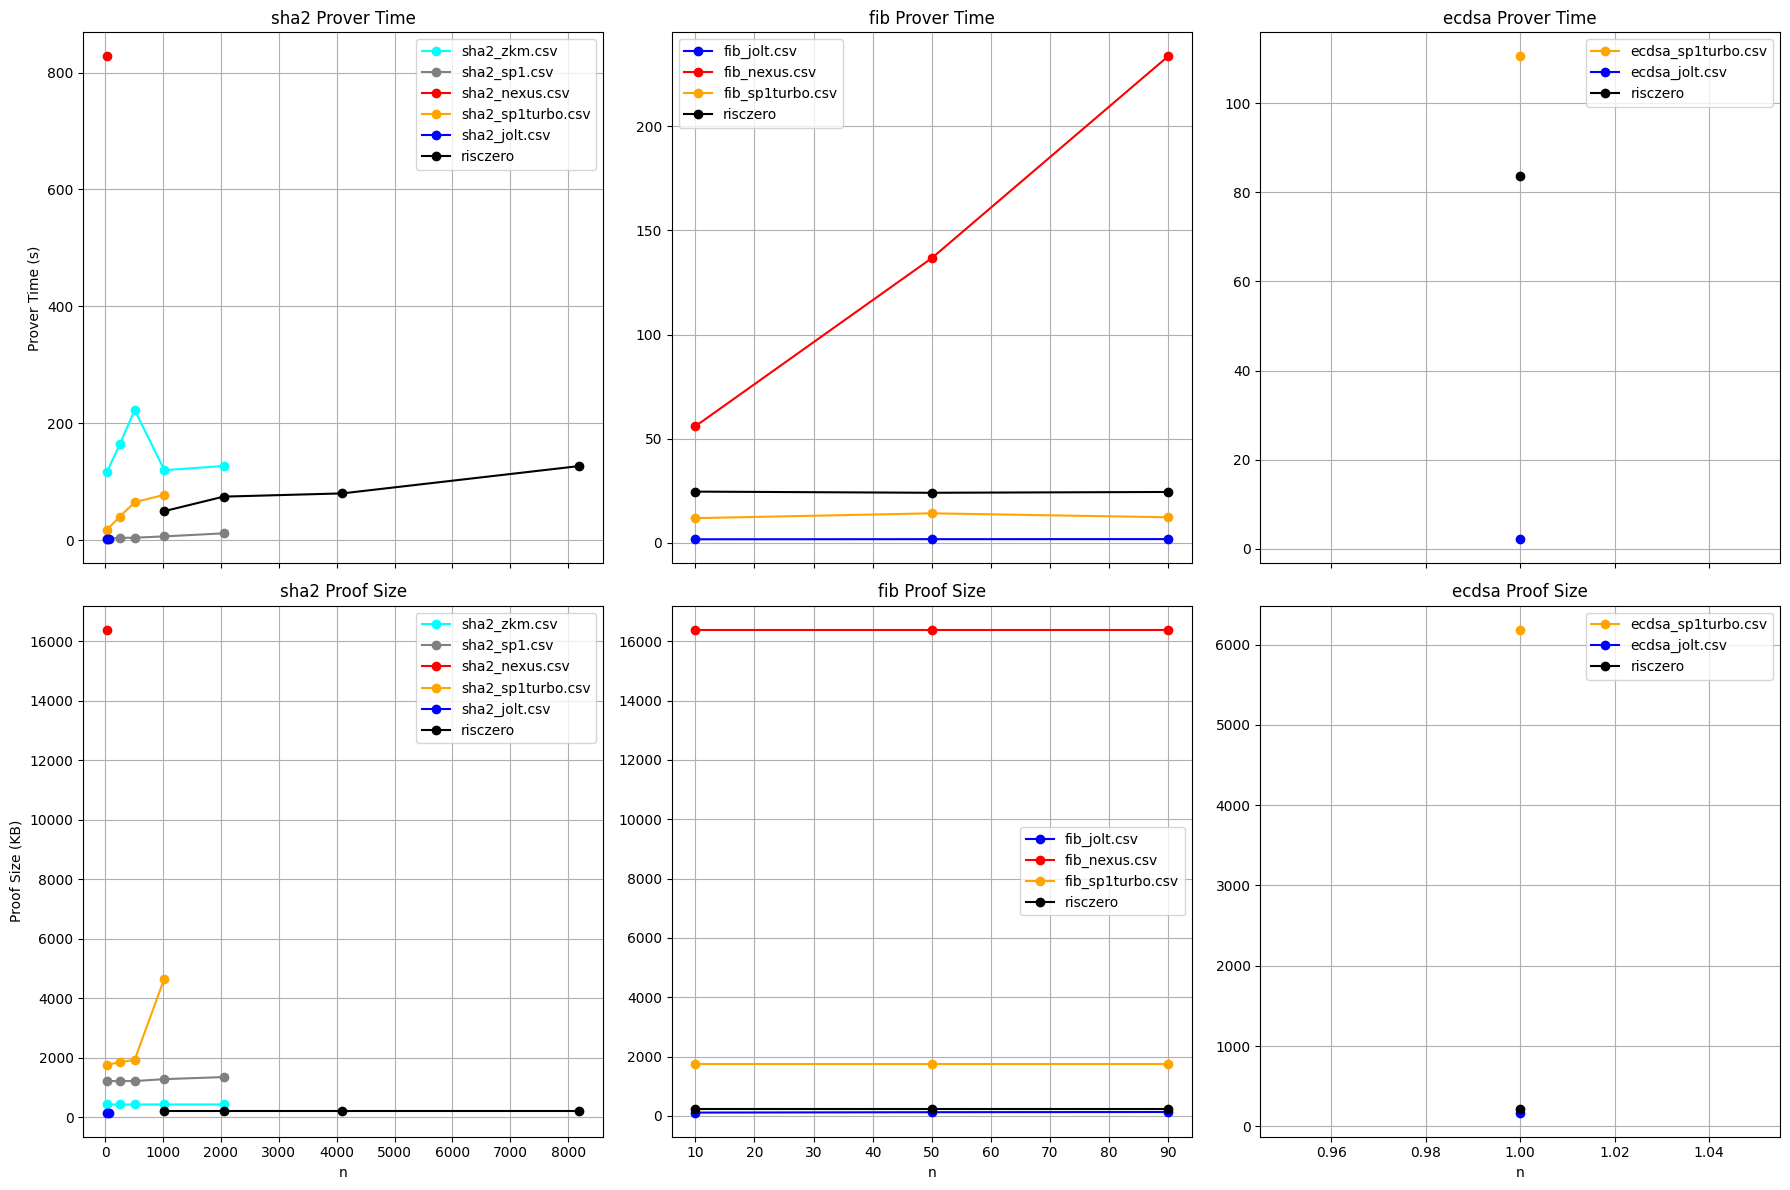

In [18]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# 固定の色対応（プロジェクト名でハードコード）
# -------------------------------
fixed_color_map = {
    "jolt": "blue",
    "sp1turbo": "orange",
    "nexus": "red",
    "sp1": "gray",
    "zkm": "cyan",
    "risczero": "black"  # risczero のデータはこのキーで統一
}

def get_fixed_color(label):
    """
    ラベル（例："ecdsa_jolt.csv" や "fib_nexus.csv"）からプロジェクト名を抽出し、
    fixed_color_map に基づいて色を返す。
    risczero の場合は、ラベルが "risczero" として統一されている前提です。
    """
    base_label = label.split('.')[0]  # 拡張子除去
    if base_label == "risczero":
        return fixed_color_map["risczero"]
    # 例: "ecdsa_jolt" → ["ecdsa", "jolt"]
    parts = base_label.split('_')
    if len(parts) > 1:
        project = parts[1]
    else:
        project = base_label
    return fixed_color_map.get(project, "black")

# -------------------------------
# 通常の CSV ファイルの処理（risczero.csv以外）
# -------------------------------
# データをグループごとにまとめる辞書。キーはグループ名、値は (label, DataFrame) のリスト
data_by_prefix = {}

for csv_file in glob.glob("*.csv"):
    if os.path.basename(csv_file) == "risczero.csv":
        continue  # risczeroは後で処理
    # 例："ecdsa_jolt.csv" → 接頭辞を取得
    prefix = os.path.basename(csv_file).split('_')[0]
  
    df = pd.read_csv(csv_file)
    # フォーマット: n, cycles, prover time (ms), proof size (bytes)
    # 単位変換: prover time (ms) → 秒, proof size (bytes) → KB
    df['prover_time_s'] = df['prover time (ms)'] / 1000.0
    df['proof_size_kb'] = df['proof size (bytes)'] / 1024.0
    df.sort_values('n', inplace=True)
    # ラベルはファイル名そのもの（例："ecdsa_jolt.csv"）
    data_by_prefix.setdefault(prefix, []).append((csv_file, df))

# -------------------------------
# risczero.csv の処理
# -------------------------------
if os.path.exists("risczero.csv"):
    df_risczero = pd.read_csv("risczero.csv")
    # risczero の横軸は 'size' ですが、これを 'n' にリネーム
    df_risczero.rename(columns={'size': 'n'}, inplace=True)
    
    # risczero の name カラムからグループ（fib, sha2, ecdsa）を決定する関数
    def map_risczero_prefix(name):
        if name.startswith("fibonacci-"):
            return "fib"
        elif name.startswith("big_sha2-"):
            return "sha2"
        elif name.startswith("ecdsa_verify"):
            return "ecdsa"
        else:
            return None
    
    df_risczero['group'] = df_risczero['name'].apply(map_risczero_prefix)
    df_risczero = df_risczero[df_risczero['group'].notna()]
    
    # 単位変換:
    # prover time は proof_duration (ナノ秒) → 秒, proof size は proof_bytes (bytes) → KB
    df_risczero['prover_time_s'] = df_risczero['proof_duration'] / 1e9
    df_risczero['proof_size_kb'] = df_risczero['proof_bytes'] / 1024.0
    
    # 各グループごとに分割し、ラベルは "risczero" として統一
    for group, subdf in df_risczero.groupby('group'):
        subdf = subdf.sort_values('n')
        data_by_prefix.setdefault(group, []).append(("risczero", subdf))

# -------------------------------
# すべてのグループを1つの図に並べる
# -------------------------------
groups = list(data_by_prefix.keys())
n_groups = len(groups)

# 2行（1行目：Prover Time, 2行目：Proof Size）、n_groups列のサブプロットを作成
fig, axes = plt.subplots(2, n_groups, figsize=(6 * n_groups, 12), sharex='col')
# axesが2次元配列になるように統一（n_groups==1の場合もリストに変換）
if n_groups == 1:
    axes = axes.reshape(2, 1)

for i, group in enumerate(groups):
    ax1 = axes[0, i]  # 上段: Prover Time
    ax2 = axes[1, i]  # 下段: Proof Size
    # 各グループ内の各データセットをプロット
    for label, df in data_by_prefix[group]:
        color = get_fixed_color(label)
        ax1.plot(df['n'], df['prover_time_s'], marker='o', color=color, label=label)
        ax2.plot(df['n'], df['proof_size_kb'], marker='o', color=color, label=label)
    
    ax1.set_title(f"{group} Prover Time")
    ax2.set_title(f"{group} Proof Size")
    ax1.grid(True)
    ax2.grid(True)
    ax2.set_xlabel("n")
    
    # 各サブプロット内の凡例は一度だけ表示
    ax1.legend()
    ax2.legend()
    
    # 左端の列のみ、y軸ラベルを表示
    if i == 0:
        ax1.set_ylabel("Prover Time (s)")
        ax2.set_ylabel("Proof Size (KB)")

fig.tight_layout()
plt.show()


In [17]:
import glob
from IPython.display import display, HTML

# カレントディレクトリ内の flamegraph_*.svg を取得（ファイル名でソート）
svg_files = sorted(glob.glob("flamegraph_*.svg"))

# 横一列に並べるためのHTMLを作成
html_str = """
<div style="display: flex; flex-direction: row; align-items: flex-start;">
"""
for svg in svg_files:
    html_str += f"""
    <div style="margin-right: 20px; text-align: center;">
        <div style="font-weight: bold; margin-bottom: 5px;">{svg}</div>
        <img src="{svg}" style="height:600px; display:block;">
    </div>
    """
html_str += "</div>"

# HTMLを表示
display(HTML(html_str))
